In [ ]:
import torch
!pip install albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [2]:
from utils import load_checkpoint
from model import UNET

In [6]:
model = UNET(in_channels=3, out_channels=1)
load_checkpoint(torch.load("my_checkpoint.pth.tar", map_location=torch.device('cpu')), model)

=> Loading checkpoint


In [7]:
IMAGE_HEIGHT = 1280//2  # 1280 originally
IMAGE_WIDTH = 1918//2 
val_transforms = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

In [9]:
from PIL import Image

img = Image.open("1.jpg")
img.show()

In [10]:
import numpy as np
img_array = np.array(img.convert("RGB"))

In [11]:
X = val_transforms(image= img_array)['image']
print(X.shape)
X = X.unsqueeze(0)
print(X.shape)

torch.Size([3, 640, 959])
torch.Size([1, 3, 640, 959])


In [61]:
with torch.no_grad():
    X = X.to('cuda')
    pred = model(X)

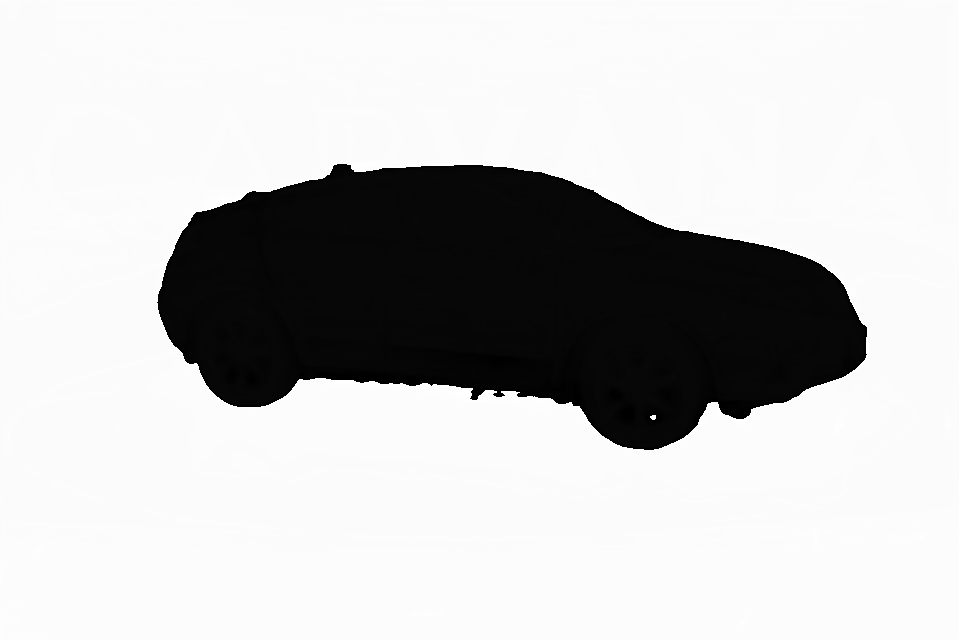

In [62]:
img2 = pred.squeeze(0).squeeze(0).cpu().numpy().astype(np.uint8)
img2 = Image.fromarray(img2, mode='L')  # 'L' mode is for grayscale
img2.show()


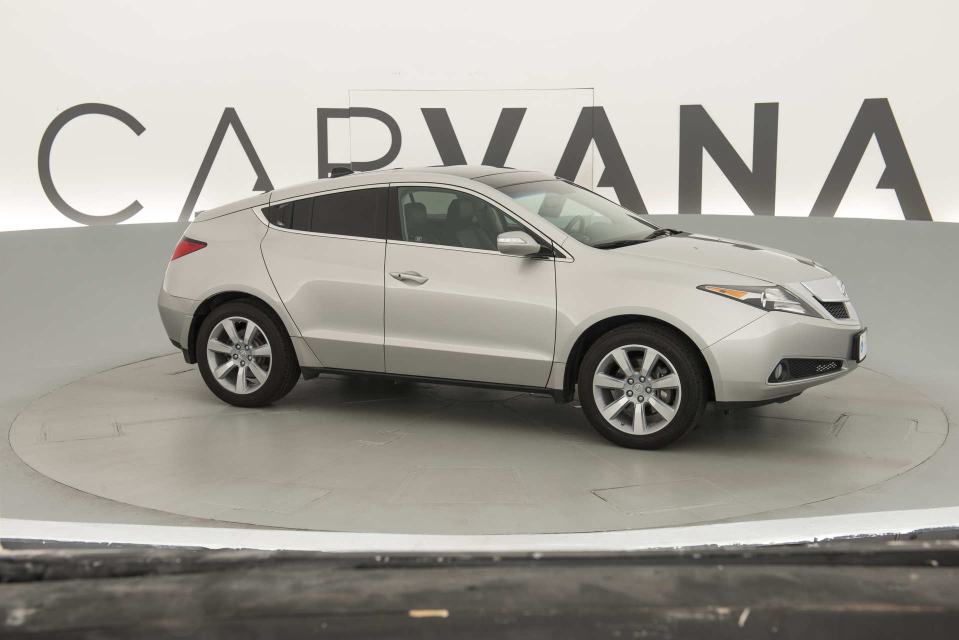

In [72]:
np_image1 = val_transforms(image= img_array)['image'].numpy()

# Step 2: Transpose the dimensions from [3, 640, 959] to [640, 959, 3]
np_image1 = np.transpose(np_image1, (1, 2, 0))

# Step 3: Convert the NumPy array to a PIL Image
pil_image = Image.fromarray((np_image1 * 255).astype(np.uint8))

# Step 4: Display the image directly using PIL
pil_image.show()


In [73]:
rgb_image = np.array(pil_image)
bw_image = np.array(img2)  # Black and white img2

rgb_image.shape, bw_image.shape

((640, 959, 3), (640, 959))

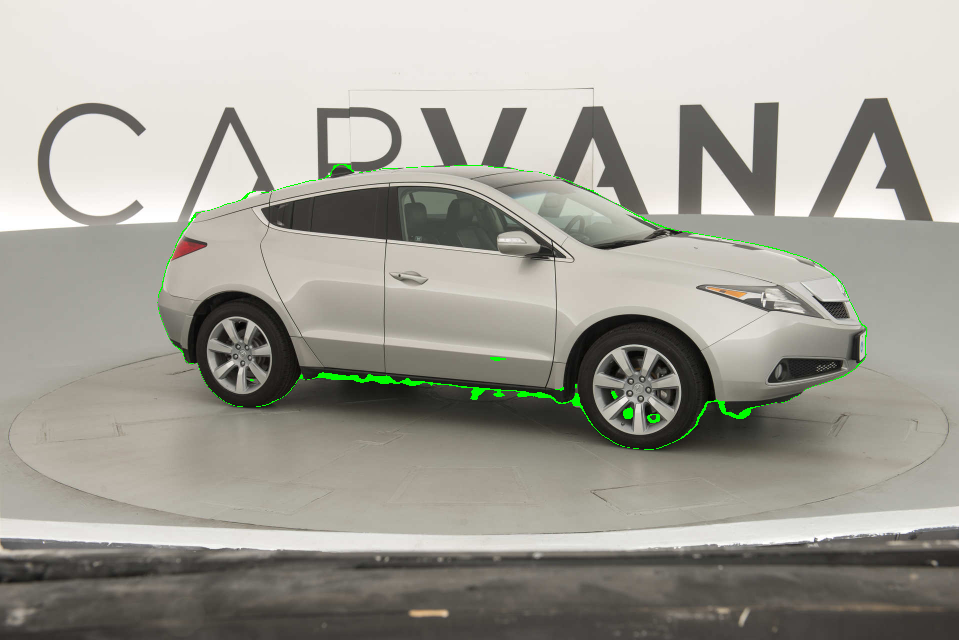

In [74]:
mask = bw_image == 0

# Step 2: Create a green mask (Green is [0, 255, 0] in RGB)
green_mask = np.zeros_like(rgb_image)
green_mask[..., 1] = 255  # Set green channel to maximum

# Step 3: Overlay the green mask onto the RGB image where the mask is True
rgb_image[mask] = green_mask[mask]

# Step 4: Convert the modified NumPy array back to a PIL image
segmented_image = Image.fromarray(rgb_image)

# Step 5: Display the result
segmented_image.show()